In [145]:
%matplotlib notebook
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import torch
from torch.profiler import record_function
from torch_geometric.nn.resolver import aggregation_resolver as aggr_resolver
import numpy as np


# Timing function for performance evaluation
import time
class catchtime:    
    def __init__(self, arg = 'Unnamed Context'):
#         print('__init__ called with', arg)
        self.context = arg
        
    def __enter__(self):
        self.time = time.perf_counter()
        return self

    def __exit__(self, type, value, traceback):
        self.time = time.perf_counter() - self.time
        self.readout = f'{self.context} took: {1000 * self.time:.3f} ms'
        print(self.readout)

# Math/parallelization library includes
import numpy as np
import torch

# Imports for neighborhood searches later on
from torch_geometric.nn import radius
from torch_scatter import scatter


# Plotting includes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import matplotlib.tri as tri
import random

from tqdm.notebook import tqdm

In [43]:


def getSpacing(n, periodic = False):
    if n == 1:
        return 2.
    else:
        return 2. / n if periodic else 2./(n-1)


centroidCache = {False:{'cuda':{},'cpu':{}},True:{'cuda':{},'cpu':{}}}
def getDistances(n, x, periodic = False):
    if n in centroidCache[periodic][x.device.type]:
        centroids = centroidCache[periodic][x.device.type][n]
        if periodic:
            spacing = getSpacing(n, True)
            offset = -1 + spacing / 2.
            ra = torch.unsqueeze(x,axis=0) - centroids
            rb = torch.unsqueeze(x,axis=0) - centroids - 2.
            rc = torch.unsqueeze(x,axis=0) - centroids + 2.
            return torch.minimum(torch.minimum(torch.abs(ra)/spacing, torch.abs(rb)/spacing), torch.abs(rc)/spacing)
        else:
            spacing = getSpacing(n, False)
            
            # centroids = torch.linspace(-1.,1.,n, device = x.device) if n > 1 else torch.constant([0.], device = x.device)
        #     tx = torch.constant(x, dtype='float32')
            r = torch.unsqueeze(x,axis=0) - centroids
            return torch.abs(r)  / spacing


    if periodic:
        spacing = getSpacing(n, True)
        offset = -1 + spacing / 2.
        
#         tx = torch.constant(x, dtype='float32')
        centroids = torch.unsqueeze(torch.linspace(-1.,1.,n+1, device = x.device)[:n],axis=1)
        centroidCache[periodic][x.device.type][n] = centroids

        ra = torch.unsqueeze(x,axis=0) - centroids
        rb = torch.unsqueeze(x,axis=0) - centroids - 2.
        rc = torch.unsqueeze(x,axis=0) - centroids + 2.
        return torch.minimum(torch.minimum(torch.abs(ra)/spacing, torch.abs(rb)/spacing), torch.abs(rc)/spacing)
        
    spacing = getSpacing(n, False)
    
    centroids = torch.linspace(-1.,1.,n, device = x.device) if n > 1 else torch.tensor([0.], device = x.device)
    centroids = torch.unsqueeze(centroids, axis = 1)
    centroidCache[periodic][x.device.type][n] = centroids
#     tx = torch.constant(x, dtype='float32')
    r = torch.unsqueeze(x,axis=0) - centroids
    return torch.abs(r)  / spacing


def evalRBFSeries(n, x, which = 'linear', epsilon = 1., periodic = False):    

    k = int(epsilon)
    r = getDistances(n, x, periodic)    
    if n == 1:
        return torch.ones_like(r)
    
    cpow = lambda x, p: torch.maximum(x, torch.zeros_like(r))**p
    
    funLib = {
        'linear': lambda r:  torch.clamp(1. - r / epsilon,0,1),
        'gaussian': lambda r:  torch.exp(-(epsilon * r)**2),
        'multiquadric': lambda r: torch.sqrt(1. + (epsilon * r) **2),
        'inverse_quadric': lambda r: 1. / ( 1 + (epsilon * r) **2),
        'inverse_multiquadric': lambda r: 1. / torch.sqrt(1. + (epsilon * r) **2),
        'polyharmonic': lambda r: torch.pow(r, k) if k % 2 == 1 else torch.pow(r,k-1) * torch.math.log(torch.pow(r,r)),
        'bump': lambda r: torch.where(r < 1./epsilon, torch.exp(-1./(1- (epsilon * r)**2)), torch.zeros_like(r)),
        'cubic_spline': lambda r: cpow(1-r/epsilon,3) - 4. * cpow(1/2-r/epsilon,3),
        'quartic_spline': lambda r: cpow(1-r/epsilon,4) - 5 * cpow(3/5-r/epsilon,4) + 10 * cpow(1/5-r/epsilon,4),
        'quintic_spline': lambda r: cpow(1-r/epsilon,5) - 6 * cpow(2/3-r/epsilon,5) + 15 * cpow(1/3-r/epsilon,5),
        'wendland2': lambda r: cpow(1 - r/epsilon, 4) * (1 + 4 * r/epsilon),
        'wendland4': lambda r: cpow(1 - r/epsilon, 6) * (1 + 6 * r/epsilon + 35/3 * (r/epsilon)**2),
        'wendland6': lambda r: cpow(1 - r/epsilon, 8) * (1 + 8 * r/epsilon + 25 * (r/epsilon) **2 + 32 * (r/epsilon)**3),
        'poly6': lambda r: cpow(1 - (r/epsilon)**2, 3),
        'spiky': lambda r: cpow(1 - r/epsilon, 3),
        'square': lambda r: torch.where(r <= epsilon, torch.ones_like(r), torch.zeros_like(r))
    }
    rbf = funLib[which]
    
#     if periodic:
#         return torch.maximum(rbf(r[0]), torch.maximum(rbf(r[1]), rbf(r[2])))
        # return torch.clip_by_value(torch.maximum(rbf(r[0]), torch.maximum(rbf(r[1]), rbf(r[2]))),0,1)   
    return rbf(r)#torch.clip_by_value(rbf(r),0,1)
    
def evalChebSeries(n,x):
    cs = []
    for i in range(n):
        if i == 0:
            cs.append(torch.ones_like(x))
        elif i == 1:
            cs.append(x)
        else:
            cs.append(2. * x * cs[i-1] - cs[i-2])
    return torch.stack(cs)
sqrt_pi_1 = 1. / np.sqrt(np.pi)

def fourier(n, x):
    if n == 0:
        return torch.ones_like(x) / np.sqrt(2. * np.pi)
    elif n % 2 == 0:
        return torch.cos((n // 2 + 1) * x) * sqrt_pi_1
    return torch.sin((n // 2 + 1) * x) * sqrt_pi_1

def evalFourierSeries(n, x):
    fs = []
    for i in range(n):
        fs.append(fourier(i, x))
    return torch.stack(fs)

def evalBasisFunction(n, x, which = 'chebyshev', periodic = False):   
    s = which.split()    
#     print(s)
    if s[0] == 'chebyshev':
        return evalChebSeries(n, x)
    if s[0] == 'fourier':
        return evalFourierSeries(n, x * np.pi)
    if s[0] == 'linear':
        return evalRBFSeries(n, x, which = 'linear', epsilon = 1., periodic = periodic)        
    if s[0] == 'rbf':
        eps = 1. if len(s) < 3 else float(s[2])
        return evalRBFSeries(n, x, which = s[1], epsilon = eps, periodic = periodic)


In [426]:
n = 8
basis = 'rbf cubic_spline'
# basis = 'linear'
weights = torch.rand(n) * 2 - 1


<IPython.core.display.Javascript object>


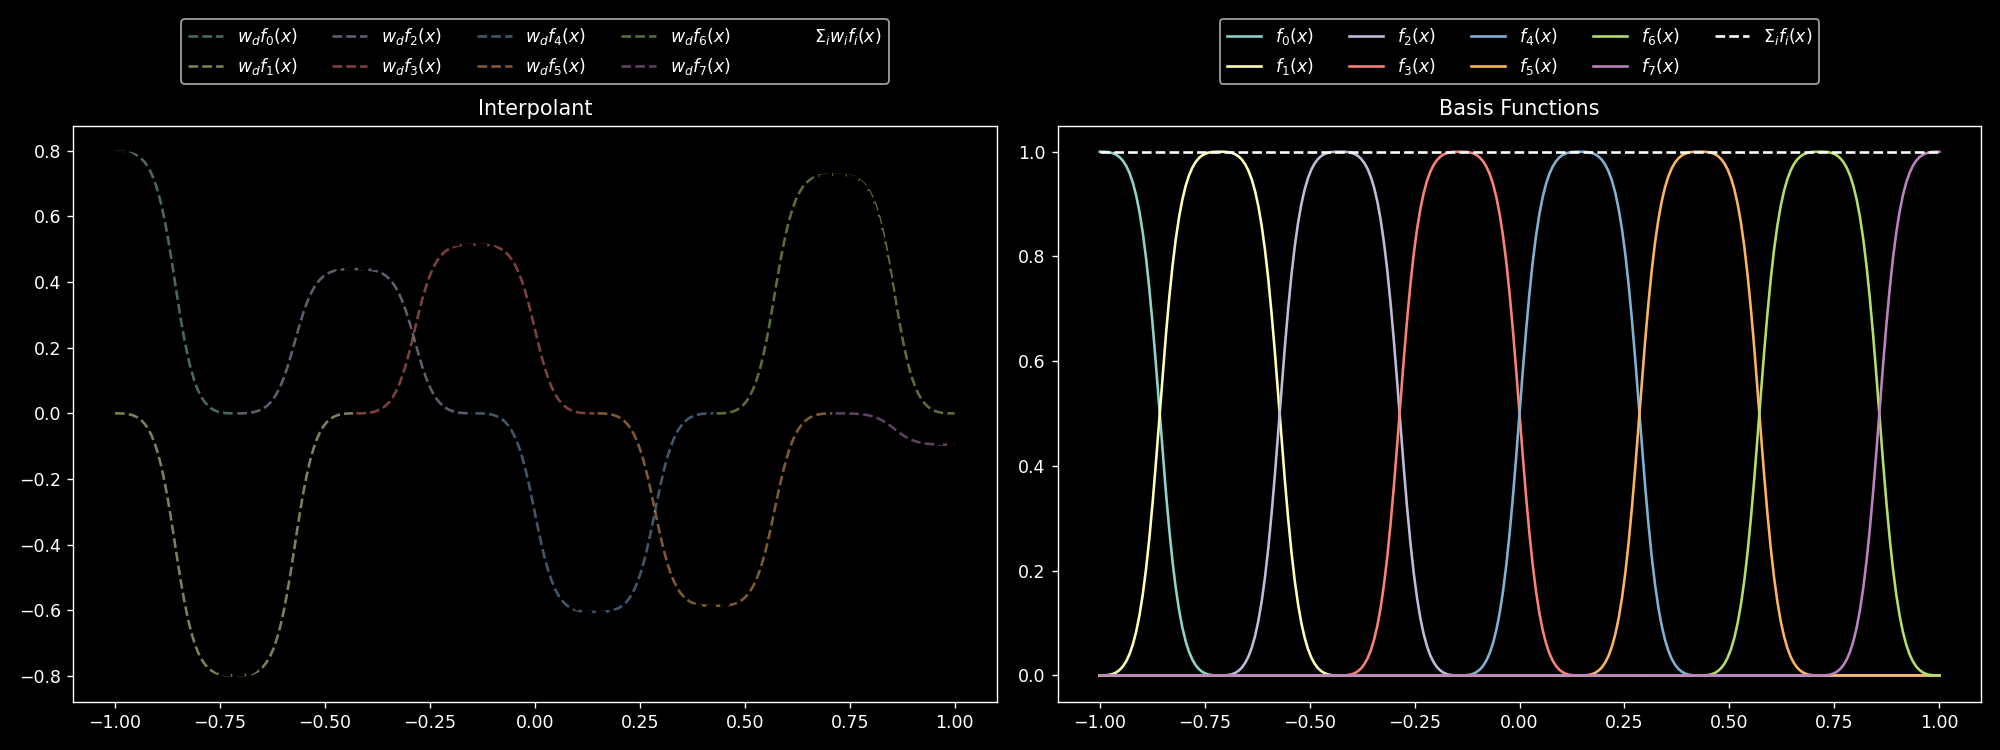

In [428]:

fig, axis = plt.subplots(1, 2, figsize=(16,6), sharex = False, sharey = False, squeeze = False)
#     sc = axis[0,0].scatter(x, y, c = c, s = 1)
#     ax1_divider = make_axes_locatable(axis[0,0])
#     cax1 = ax1_divider.append_axes("bottom", size="20%", pad="2%")
#     cb1 = fig.colorbar(sc, cax=cax1,orientation='horizontal')
#     cb1.ax.tick_params(labelsize=8) 
#     axis[0,0].axvline(minDomain, color = 'black', ls = '--')
#     axis[0,0].axvline(maxDomain, color = 'black', ls = '--')

x =  torch.linspace(-1,1,255)
fx = evalBasisFunction(n, x , which = basis, periodic=False)
fx = fx / torch.sum(fx, axis = 0)[None,:]

for y in range(n):
#     print(y)
    axis[0,1].plot(x, fx[y,:], label = '$f_%d(x)$' % y)
axis[0,1].plot(x,torch.sum(fx, axis=0),ls='--',c='white', label = '$\Sigma_i f_i(x)$')
# axis[0,0].legend()
axis[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=5, fancybox=True, shadow=False)
axis[0,1].set_title('Basis Functions')
# x =  torch.linspace(-1,1,255)
# fx = evalBasisFunction(8, x , which = 'linear', periodic=False)
# fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)
for y in range(n):
#     print(y)
    fy = weights[y].detach() * fx[y,:]
    axis[0,0].plot(x[fy != 0], fy[fy != 0], label = '$w_d f_%d(x)$' % y, ls = '--', alpha = 0.5)
# axis[0,1].plot(x,torch.sum(fx, axis=0),ls='--',c='black', label = '$\Sigma_i f_i(x)$')
axis[0,0].plot(x,torch.sum(weights[:,None].detach() * fx, axis=0),ls='--',c='black', label = '$\Sigma_i w_i f_i(x)$')
# axis[0,0].legend()
axis[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=5, fancybox=True, shadow=False)

axis[0,0].set_title('Interpolant')
fig.tight_layout()

  0%|          | 0/256 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


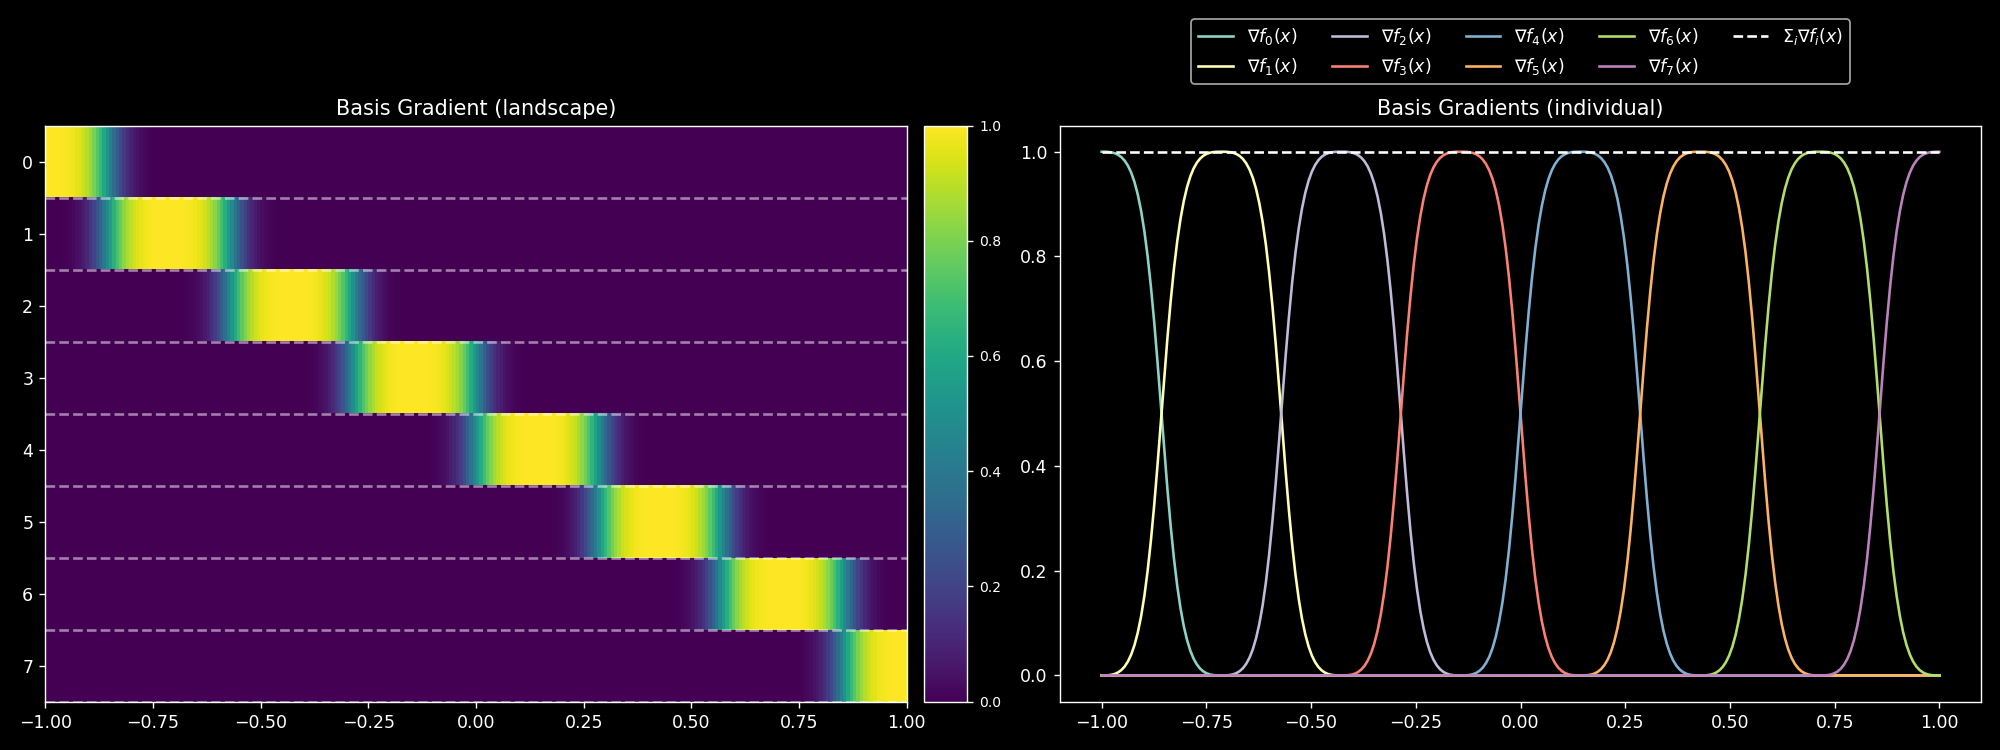

In [430]:
nx = 256
grads = []
for i in tqdm(range(nx)):
    x = torch.tensor([-1 + 2 / (nx - 1) * i], dtype = torch.float32)
    weights.grad = torch.zeros(weights.shape)
    weights.requires_grad = True
    fx = evalBasisFunction(n, x , which = basis, periodic=False)
    fx = fx / torch.sum(fx, axis = 0)[None,:]
    wfx = torch.sum(weights[:,None] * fx, axis = 0)
    wfx.backward()
    grads.append(torch.clone(weights.grad))
grads = torch.vstack(grads)

fig, axis = plt.subplots(1, 2, figsize=(16,6), sharex = False, sharey = False, squeeze = False)

im = axis[0,0].imshow(grads.mT, aspect = 'auto', extent = [-1,1, weights.shape[0],0], interpolation = 'nearest')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="5%", pad="2%")
cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
cb1.ax.tick_params(labelsize=8) 

axis[0,0].set_yticks([x + 0.5 for x in range(weights.shape[0])])
axis[0,0].set_yticklabels([x for x in range(weights.shape[0])])
for i in range(weights.shape[0]):
    axis[0,0].axhline(i + 1, ls = '--', alpha = 0.5, c = 'white')
axis[0,0].set_title('Basis Gradient (landscape)')
for y in range(weights.shape[0]):
    axis[0,1].plot(torch.linspace(-1,1,nx), grads[:,y], label = '$\\nabla f_%d(x)$' % y)
axis[0,1].plot(torch.linspace(-1,1,nx), torch.sum(grads,axis=1),ls='--',c='white', label = '$\Sigma_i \\nabla f_i(x)$')
    
axis[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=5, fancybox=True, shadow=False)

axis[0,1].set_title('Basis Gradients (individual)')
fig.tight_layout()

In [235]:
target = lambda x: torch.sin(x * np.pi)

<IPython.core.display.Javascript object>


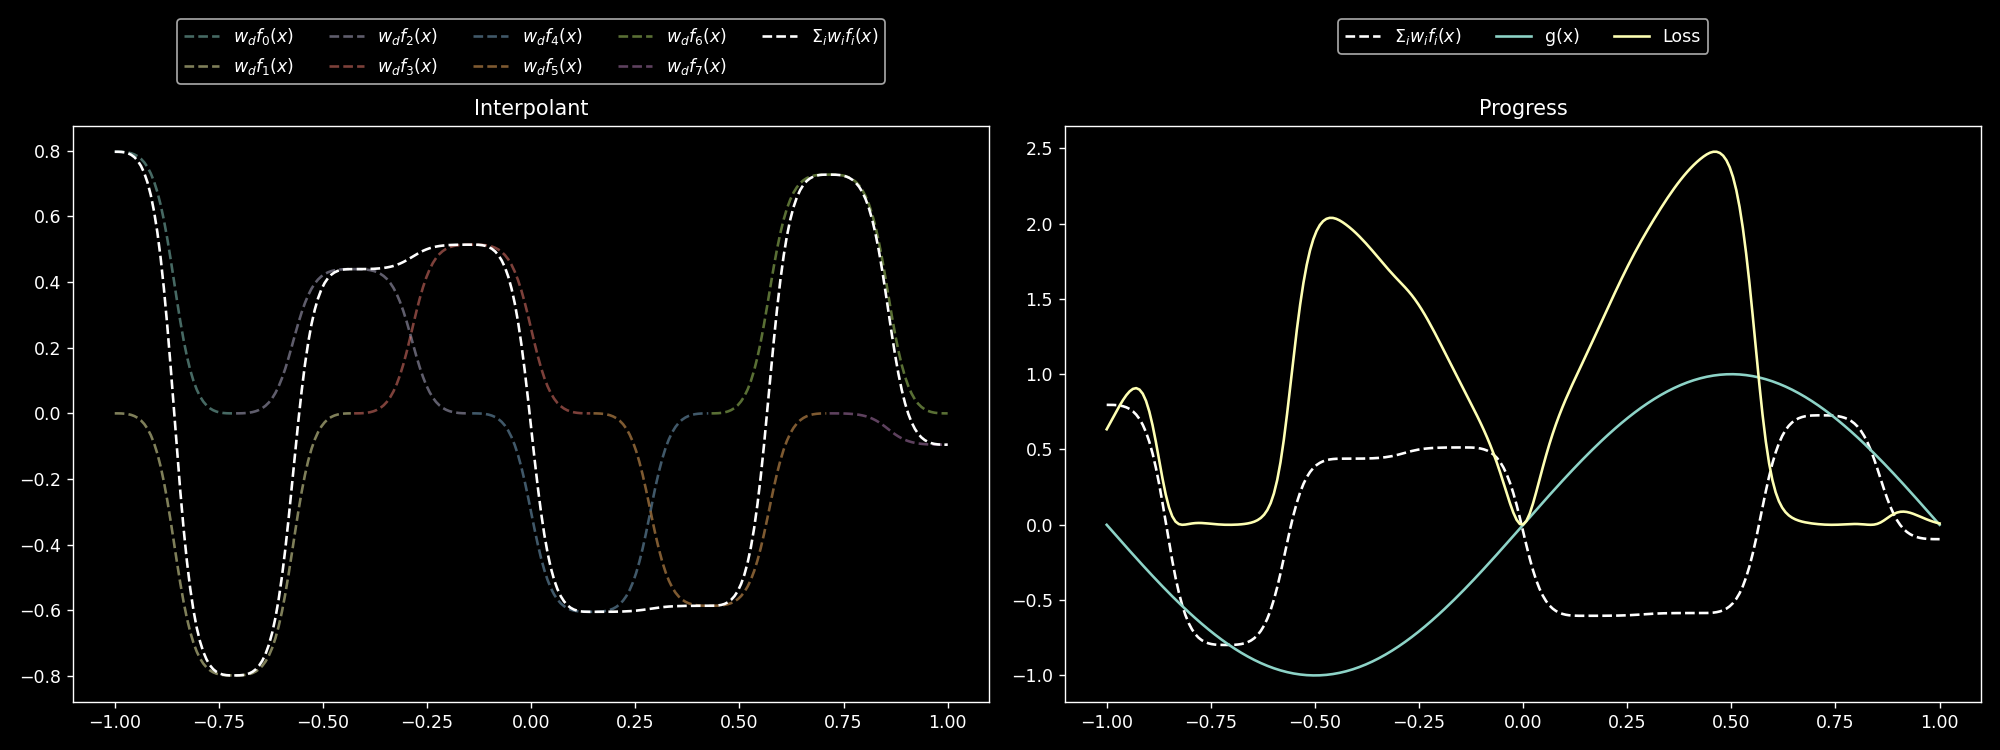

In [433]:

fig, axis = plt.subplots(1, 2, figsize=(16,6), sharex = False, sharey = False, squeeze = False)
#     sc = axis[0,0].scatter(x, y, c = c, s = 1)
#     ax1_divider = make_axes_locatable(axis[0,0])
#     cax1 = ax1_divider.append_axes("bottom", size="20%", pad="2%")
#     cb1 = fig.colorbar(sc, cax=cax1,orientation='horizontal')
#     cb1.ax.tick_params(labelsize=8) 
#     axis[0,0].axvline(minDomain, color = 'black', ls = '--')
#     axis[0,0].axvline(maxDomain, color = 'black', ls = '--')

x =  torch.linspace(-1,1,255)
fx = evalBasisFunction(n, x , which = basis, periodic=False)
fx = fx / torch.sum(fx, axis = 0)[None,:]


for y in range(n):
#     print(y)
    fy = weights[y].detach() * fx[y,:]
    axis[0,0].plot(x[fy != 0], fy[fy != 0], label = '$w_d f_%d(x)$' % y, ls = '--', alpha = 0.5)
# axis[0,1].plot(x,torch.sum(fx, axis=0),ls='--',c='black', label = '$\Sigma_i f_i(x)$')
axis[0,0].plot(x,torch.sum(weights[:,None].detach() * fx, axis=0),ls='--',c='white', label = '$\Sigma_i w_i f_i(x)$')
# axis[0,0].legend()
axis[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=5, fancybox=True, shadow=False)

axis[0,0].set_title('Interpolant')

axis[0,1].plot(x,torch.sum(weights[:,None].detach() * fx, axis=0),ls='--',c='white', label = '$\Sigma_i w_i f_i(x)$')
axis[0,1].plot(x, target(x),label = 'g(x)')
axis[0,1].plot(x, (torch.sum(weights[:,None].detach() * fx, axis=0) - target(x))**2, label = 'Loss')
axis[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=5, fancybox=True, shadow=False)
axis[0,1].set_title('Progress')
fig.tight_layout()

In [243]:
weights.requires_grad = False
weights.grad = torch.zeros(weights.shape)
weights.requires_grad = True
loss = torch.sum((torch.sum(weights[:,None] * fx, axis=0) - target(x))**2)
loss.backward()
print(loss)

tensor(361.1433, grad_fn=<SumBackward0>)


In [500]:
print(weights)
print(torch.sin(torch.linspace(-1,1,32) * np.pi))

tensor([-1.3081e-04, -2.0195e-01, -3.9573e-01, -5.7324e-01, -7.2730e-01,
        -8.5149e-01, -9.4096e-01, -9.9188e-01, -1.0022e+00, -9.7141e-01,
        -9.0083e-01, -7.9347e-01, -6.5362e-01, -4.8698e-01, -3.0039e-01,
        -1.0151e-01,  1.0151e-01,  3.0039e-01,  4.8698e-01,  6.5362e-01,
         7.9347e-01,  9.0083e-01,  9.7142e-01,  1.0022e+00,  9.9188e-01,
         9.4096e-01,  8.5149e-01,  7.2730e-01,  5.7324e-01,  3.9573e-01,
         2.0195e-01,  1.3115e-04], requires_grad=True)
tensor([ 8.7423e-08, -2.0130e-01, -3.9436e-01, -5.7127e-01, -7.2479e-01,
        -8.4864e-01, -9.3775e-01, -9.8847e-01, -9.9872e-01, -9.6808e-01,
        -8.9780e-01, -7.9078e-01, -6.5137e-01, -4.8530e-01, -2.9936e-01,
        -1.0117e-01,  1.0117e-01,  2.9936e-01,  4.8530e-01,  6.5137e-01,
         7.9078e-01,  8.9780e-01,  9.6808e-01,  9.9872e-01,  9.8847e-01,
         9.3775e-01,  8.4864e-01,  7.2479e-01,  5.7127e-01,  3.9436e-01,
         2.0130e-01, -8.7423e-08])


In [245]:

import torch.optim as optim

In [599]:
n = 8
basis = 'rbf cubic_spline 2'
# basis = 'linear'
weights = torch.rand(n) * 2 - 1

x =  torch.linspace(-1,1,255)
fx = evalBasisFunction(n, x , which = basis, periodic=False)

In [600]:
fx = fx / torch.sum(fx, axis = 0)[None,:]

In [601]:
torch.sum(fx / torch.sum(fx,axis = 0),axis = 0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [602]:
weights = torch.rand(n)
# weights = torch.sin(torch.linspace(-1,1,n) * np.pi)
weights.requires_grad = True
optimizer = optim.SGD([weights], lr=1e-2, momentum=0.9)

In [603]:
weightList = []
gradList = []
weightList.append(torch.clone(weights.detach()))

In [604]:
for i in range(256):
    optimizer.zero_grad()

    loss = torch.sum((torch.sum(weights[:,None] * fx, axis=0) - target(x))**2)
    loss.backward()

    gradList.append(torch.clone(weights.grad.detach()))
    optimizer.step()
    weightList.append(torch.clone(weights))

In [605]:
# weightList

In [606]:
# gradList

In [607]:
import matplotlib as mpl
plt.style.use('dark_background')
cmap = mpl.colormaps['viridis']

<IPython.core.display.Javascript object>


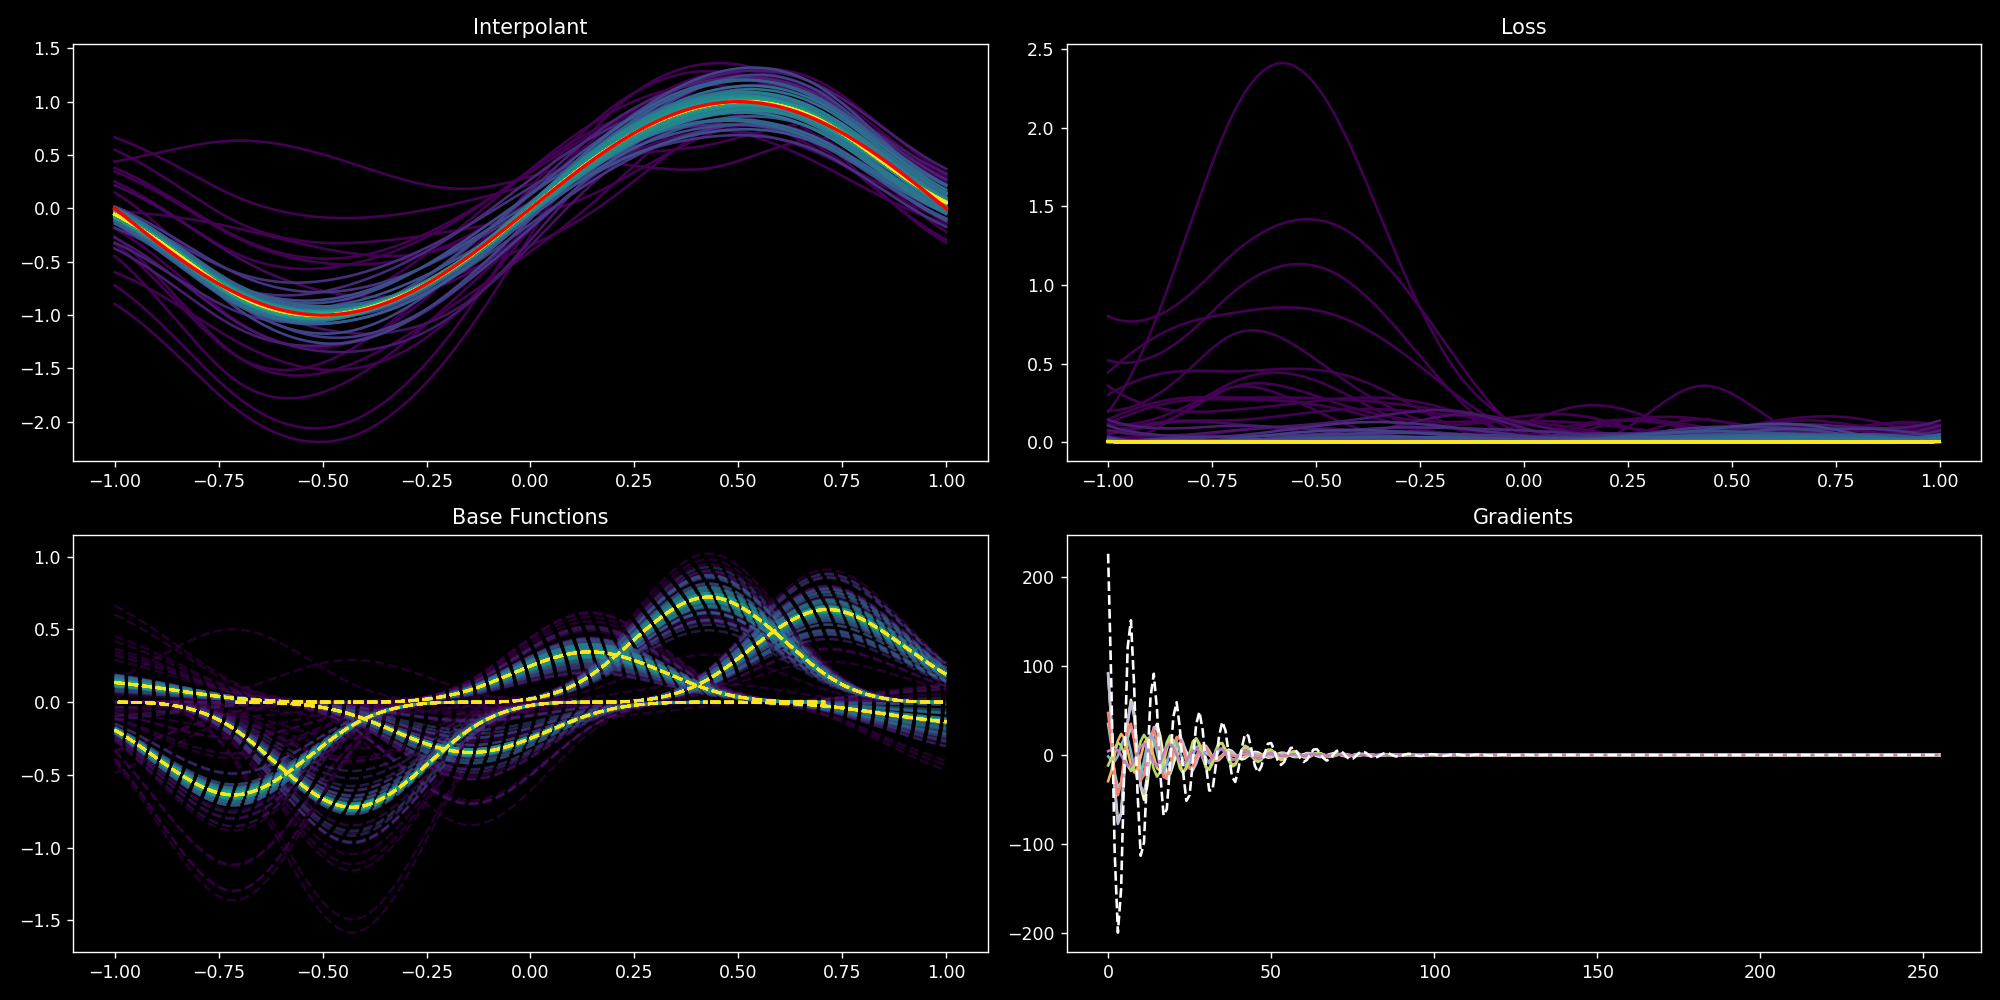

In [608]:

fig, axis = plt.subplots(2, 2, figsize=(16,8), sharex = False, sharey = False, squeeze = False)
#     sc = axis[0,0].scatter(x, y, c = c, s = 1)
#     ax1_divider = make_axes_locatable(axis[0,0])
#     cax1 = ax1_divider.append_axes("bottom", size="20%", pad="2%")
#     cb1 = fig.colorbar(sc, cax=cax1,orientation='horizontal')
#     cb1.ax.tick_params(labelsize=8) 
#     axis[0,0].axvline(minDomain, color = 'black', ls = '--')
#     axis[0,0].axvline(maxDomain, color = 'black', ls = '--')

x =  torch.linspace(-1,1,255)
fx = evalBasisFunction(n, x , which = basis, periodic=False)
fx = fx / torch.sum(fx, axis = 0)[None,:]

import matplotlib.colors as colors
norm = colors.LogNorm(vmin=1, vmax=len(weightList))

for i, w in enumerate(weightList):
    c = cmap(-1 + 2 / (len(weightList) - 1)* i)
    c = cmap(norm(i + 1) *2 -1)
    for y in range(n):
        fy = w[y].detach() * fx[y,:]
        axis[1,0].plot(x[fy != 0], fy[fy != 0], label = '$w_d f_%d(x)$' % y, ls = '--', alpha = 0.5,c = c)
        
    axis[0,0].plot(x,torch.sum(w[:,None].detach() * fx, axis=0),ls='-',c=c, label = 'epoch %d' % i)
    loss = (torch.sum(w.detach()[:,None] * fx, axis=0) - target(x))**2
    axis[0,1].plot(x, loss,c=c)
#     axis[2,0].plot(x,torch.sum(w[:,None].detach() * fx, axis=0),ls='-',c=cmap(-1 + 2 / (len(weightList) - 1)* i), label = '$\Sigma_i w_i f_i(x)$')
    
#     print(w)
    
gradListTensor = torch.vstack(gradList)
for i in range(n):
    axis[1,1].plot(gradListTensor[:,i])
    
axis[1,1].plot(torch.sum(gradListTensor, axis=1), c = 'white', ls = '--')
# for i, g in enumerate(gradList):
#     axis[1,1].scatter(torch.arange(g.shape[0]), g, s = 4,color=cmap(-1 + 2 / (len(weightList) - 1)* i))
    
#     axis[1,1].grid(True)
#     axis[1,1].plot(x, g,c=cmap(-1 + 2 / (len(gradList) - 1)* i))
    
axis[0,0].plot(x, target(x),label = 'target',lw=2,c='red')
    
axis[0,0].set_title('Learning Progress')
axis[0,1].set_title('Loss')
axis[1,0].set_title('Base Functions')
axis[1,1].set_title('Gradients')
# axis[0,0].legend()
# axis[0,0].legend(loc='right', bbox_to_anchor=(1.15, 0.8),
#           ncol=1, fancybox=True, shadow=False)

axis[0,0].set_title('Interpolant')

# axis[0,1].plot(x,torch.sum(weights[:,None].detach() * fx, axis=0),ls='--',c='black', label = '$\Sigma_i w_i f_i(x)$')
# axis[0,1].plot(x, target(x),label = 'g(x)')
# axis[0,1].plot(x, (torch.sum(weights[:,None].detach() * fx, axis=0) - target(x))**2, label = 'Loss')
# axis[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
#           ncol=5, fancybox=True, shadow=False)
# axis[0,1].set_title('Progress')
fig.tight_layout()

In [372]:
norm(len(weightList))

1.0